In [164]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
from activ.readfile import load_data
from activ.pipeline import score_clusters_cv, cluster_range, filter_outliers, run_umap
from activ.data_normalization import data_normalization
import h5py
from bokeh.plotting import figure, output_file, show
from bokeh.models import CategoricalColorMapper, ColumnDataSource
from bokeh.palettes import Category10, Category20
from bokeh.io import output_notebook
from umap import UMAP
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.model_selection import train_test_split, cross_val_score
import deepdish as dd

In [166]:
def read_h5(filename):
    f = h5py.File(filename, 'r')
    data = f['data'][:]
    return data.T

In [167]:
bm_W1 = '/Users/ahyeon/Desktop/TBIanalysis/data_matrix_subset_biomarker.h5'
bm_H1 = '/Users/ahyeon/Desktop/TBIanalysis/data_matrix_subset_biomarker_H1.h5'
oc_W1 = '/Users/ahyeon/Desktop/TBIanalysis/data_matrix_subset_outcome.h5'
oc_H1 = '/Users/ahyeon/Desktop/TBIanalysis/data_matrix_subset_outcome_H1.h5'

bm_w1 = read_h5(bm_W1)
bm_h1 = read_h5(bm_H1)
oc_w1 = read_h5(oc_W1)
oc_h1 = read_h5(oc_H1)

In [168]:
bm_w1.shape

(247, 23)

In [169]:
filename = '/Users/ahyeon/Desktop/TBIanalysis/data/data.h5'
with h5py.File(filename, 'r') as f:
    data_bm = f['data_matrix_subset_biomarker'][:]
    data_oc = f['data_matrix_subset_outcome'][:]
    feature_bm = f['feature_name_subset_biomarker'][:]
    feature_oc = f['feature_name_subset_outcome'][:]
    pid = f['patient_id'][:]

In [170]:
bm_w1,indices= filter_outliers(bm_w1,10)
oc_w1,indices = filter_outliers(oc_w1,10)
data_oc, indices = filter_outliers(data_oc.T,10)

In [171]:
bm_w1.shape

(237, 23)

In [172]:
data_oc.shape

(237, 177)

In [173]:
def umap_pipeline(iteration, test_data, dataname):
    umap_dims = np.arange(2,11) #11
    clusters = np.arange(2,15) #15
    score = np.zeros((iteration, len(umap_dims), len(clusters), 10))
    norm_score = np.zeros((iteration, len(umap_dims), len(clusters), 10))
    embdict = {}
    treedict = {}
    
    for x in range(iteration):
        embeddings = []
        trees = []
        for ii,k in enumerate(umap_dims): # umap dimension
            embedding = run_umap(data_oc, k, n_neighbors=10,min_dist=0.001)
            Z = hierarchy.linkage(embedding, 'ward', optimal_ordering=True)
            trees.append(Z)
            for jj,c in enumerate(clusters): # cluster
                labels = hierarchy.cut_tree(Z, n_clusters=c).reshape(237)
                score[x,ii,jj] = cross_val_score(RFC(100), test_data, labels, cv=10)
                norm_score[x,ii,jj] = cross_val_score(RFC(100), test_data, np.random.permutation(labels), cv=10)
        embdict[x] = embeddings
        treedict[x] = trees
        print(x)
    return score, norm_score, embdict, treedict

In [174]:
score, norm_score, emb, tree = umap_pipeline(1, bm_w1, 'data_bm')

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 9 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: W

/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 7 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: W

0


In [175]:
score_new = np.squeeze(score)
norm_score = np.squeeze(norm_score)
score_new.shape

(9, 13, 10)

In [176]:
score2 = score_new/norm_score.mean(axis=-1, keepdims=True)
med_score = np.median(score2, axis=-1)
max_score = np.amax(score2, axis=-1)
mean_score = np.mean(score2,axis=-1)
med_score.shape

(9, 13)

Text(0.5,1,'Median Prediction Accuracy')

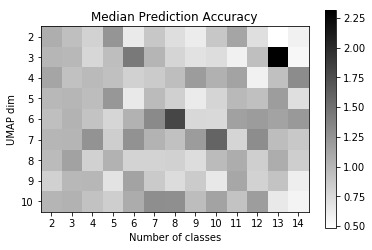

In [177]:
f, ax = plt.subplots(1)
im = ax.imshow(med_score, cmap='gray_r')
f.colorbar(im)
clusters = np.arange(2,15)
umap_dims = np.arange(2,11)
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters)
ax.set_xlabel('Number of classes')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Median Prediction Accuracy')


Text(0.5,1,'Mean Prediction Accuracy')

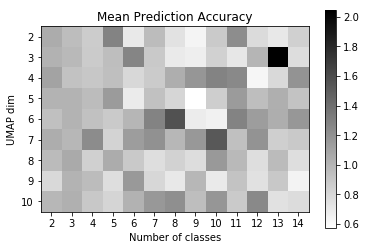

In [178]:
f, ax = plt.subplots(1)
im = ax.imshow(mean_score, cmap='gray_r')
f.colorbar(im)
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters)
ax.set_xlabel('Number of classes')
ax.set_yticks(np.arange(len(umap_dims)))
ax.set_yticklabels(umap_dims)
ax.set_ylabel('UMAP dim')
ax.set_title('Mean Prediction Accuracy')


/Users/ahyeon/anaconda3/envs/activ/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `spline` is deprecated!
spline is deprecated in scipy 0.19.0, use Bspline class instead.
  # Remove the CWD from sys.path while we load stuff.


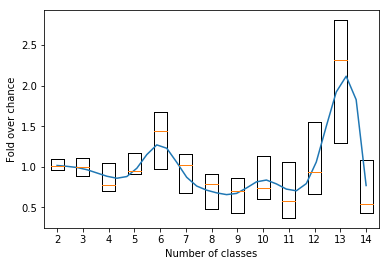

In [180]:
from scipy.interpolate import spline

plt.figure()
for x in clusters:
    plt.boxplot(score2[1].T, whis=[25,75], positions=clusters, sym='')
plt.xlabel('Number of classes')
plt.ylabel('Fold over chance')

xnew = np.linspace(2,14,32) 
power_smooth = spline(clusters,score2[1].mean(axis=1),xnew)
plt.plot(xnew,power_smooth)
plt.savefig('/Users/ahyeon/Desktop/activ/bin/umapboxplot.pdf')

plt.show()

In [181]:
score_new.shape

(9, 13, 10)

In [188]:
mat_score = score_new[5,:,:]
len(mat_score)

13

[[ 1.         -0.16596632 -0.20338016 -0.04066878 -0.38110052 -0.67765434
  -0.43656591  0.03663733 -0.50737295  0.03525466]
 [-0.01762078  1.          0.60365466 -0.32978425 -0.24476812 -0.16143809
  -0.41742192 -0.20012414 -0.47696944  0.36334609]
 [ 0.10147989  0.78659589  1.         -0.84003274 -0.57200278 -0.58441775
  -0.67617937 -0.14706493 -0.77699318  0.15530472]
 [-0.24067097 -0.59560542 -0.94893782  1.          0.5616053   0.65351747
   0.70234628  0.13427014  0.86617463  0.04529649]
 [-0.46333085 -0.31985164 -0.73968486  0.8868454   1.          0.64037294
   0.7890429  -0.13586894  0.8742058   0.01087706]
 [-0.81254088 -0.33284349 -0.68890333  0.87384403  0.88732888  1.
   0.69322042  0.18746496  0.86729886  0.04816467]
 [-0.51610925 -0.39925995 -0.76160587  0.92729499  0.94047926  0.91085257
   1.         -0.03844889  0.86065846  0.02419383]
 [ 0.09540552 -0.24865131 -0.29236461  0.42829657  0.20142893  0.41055699
   0.33473444  1.          0.23893384 -0.26921691]
 [-0.613

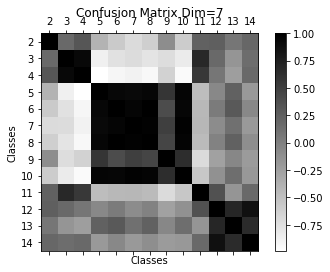

In [190]:
import scipy.spatial.distance as spd

confusion = np.zeros((len(mat_score), len(mat_score)))
for i in range(len(mat_score)):
    for j in range(len(mat_score)):
        val0 = mat_score[i]
        val0 = val0 - val0.mean(keepdims=True)
        val0 /= np.linalg.norm(val0,keepdims=True)
        val1 = mat_score[j]
        val1 = val1 - val1.mean(keepdims=True)
        val1 /= np.linalg.norm(val1, keepdims=True)
        x = (val0*val1).sum().mean()
        confusion[i,j] = x
print(mat_score)
#mat_score = spd.pdist(score_new[5,:10,:10], 'correlation')
f, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='gray_r')
f.colorbar(im)
ax.set_xticks(np.arange(len(clusters)))
ax.set_xticklabels(clusters)
ax.set_xlabel('Classes')
ax.set_yticks(np.arange(len(clusters)))
ax.set_yticklabels(clusters)
ax.set_ylabel('Classes')
ax.set_title('Confusion Matrix Dim={}'.format(7))
plt.savefig('/Users/ahyeon/Desktop/activ/bin/confusionmatrix.pdf')